<a href="https://colab.research.google.com/github/iptkachev/ab_platform/blob/master/play_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# unzip archives

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
! for VARIABLE in /content/drive/MyDrive/dls_part1_project_vto/*; do echo "start $VARIABLE"; unzip -q $VARIABLE; done

start /content/drive/MyDrive/dls_part1_project_vto/models_smplx_v1_1.zip
replace models/smplx/SMPLX_NEUTRAL.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# frankmocap

In [5]:
# INSTALL ENVORIMENT

In [6]:
# download frankmocap repo and copy smpl models to repo
! git clone https://github.com/facebookresearch/frankmocap.git
! mkdir -p ./frankmocap/extra_data/smpl
! cp /content/smplify_public/code/models/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl ./frankmocap/extra_data/smpl/
! cp /content/models/smplx/SMPLX_NEUTRAL.pkl ./frankmocap/extra_data/smpl/

fatal: destination path 'frankmocap' already exists and is not an empty directory.


In [7]:
# install dependencies using https://github.com/facebookresearch/frankmocap/blob/main/docs/INSTALL.md

! pip install -q torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
! python -m pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
! pip install -q torchgeometry pytorch3d
! cd frankmocap && pip install -q -r docs/requirements.txt
! cd frankmocap && sh scripts/install_frankmocap.sh &> /dev/null

In [8]:
# from google.colab.patches import cv2_imshow to frankmocap/renderer/viewer2D.py:6
# cv2_imshow(inputImg) to renderer/viewer2D.py:30

In [66]:
import os
import sys
os.chdir("/content/frankmocap")
sys.path.append("/content/frankmocap/detectors/hand_object_detector/lib")  # for import models.utils.config
sys.path.append("/content/frankmocap/detectors/body_pose_estimator")

In [67]:
# RUN CODE

In [68]:
class DemoOptions:

    def __init__(self):
        parser = argparse.ArgumentParser()
        
        # parser.add_argument('--checkpoint', required=False, default=default_checkpoint, help='Path to pretrained checkpoint')
        default_checkpoint_body_smpl ='./extra_data/body_module/pretrained_weights/2020_05_31-00_50_43-best-51.749683916568756.pt'
        parser.add_argument('--checkpoint_body_smpl', required=False, default=default_checkpoint_body_smpl, help='Path to pretrained checkpoint')
        default_checkpoint_body_smplx ='./extra_data/body_module/pretrained_weights/smplx-03-28-46060-w_spin_mlc3d_46582-2089_2020_03_28-21_56_16.pt'
        parser.add_argument('--checkpoint_body_smplx', required=False, default=default_checkpoint_body_smplx, help='Path to pretrained checkpoint')
        default_checkpoint_hand = "./extra_data/hand_module/pretrained_weights/pose_shape_best.pth"
        parser.add_argument('--checkpoint_hand', required=False, default=default_checkpoint_hand, help='Path to pretrained checkpoint')

        # input options
        parser.add_argument('--input_path', type=str, default=None, help="""Path of video, image, or a folder where image files exists""")
        parser.add_argument('--start_frame', type=int, default=0, help='given a sequence of frames, set the starting frame')
        parser.add_argument('--end_frame', type=int, default=float('inf'), help='given a sequence of frames, set the last frame')
        parser.add_argument('--pkl_dir', type=str, help='Path of storing pkl files that store the predicted results')
        parser.add_argument('--openpose_dir', type=str, help='Directory of storing the prediction of openpose prediction')

        # output options
        parser.add_argument('--out_dir', type=str, default=None, help='Folder of output images.')
        # parser.add_argument('--pklout', action='store_true', help='Export mocap output as pkl file')
        parser.add_argument('--save_bbox_output', action='store_true', help='Save the bboxes in json files (bbox_xywh format)')
        parser.add_argument('--save_pred_pkl', action='store_true', help='Save the predictions (bboxes, params, meshes in pkl format')
        parser.add_argument("--save_mesh", action='store_true', help="Save the predicted vertices and faces")
        parser.add_argument("--save_frame", action='store_true', help='Save the extracted frames from video input or webcam')

        # Other options
        parser.add_argument('--single_person', action='store_true', help='Reconstruct only one person in the scene with the biggest bbox')
        parser.add_argument('--no_display', action='store_true', help='Do not visualize output on the screen')
        parser.add_argument('--no_video_out', action='store_true', help='Do not merge rendered frames to video (ffmpeg)')
        parser.add_argument('--smpl_dir', type=str, default='./extra_data/smpl/', help='Folder where smpl files are located.')
        parser.add_argument('--skip', action='store_true', help='Skip there exist already processed outputs')
        parser.add_argument('--video_url', type=str, default=None, help='URL of YouTube video, or image.')
        parser.add_argument('--download', '-d', action='store_true', help='Download YouTube video first (in webvideo folder), and process it')

        # Body mocap specific options
        parser.add_argument('--use_smplx', action='store_true', help='Use SMPLX model for body mocap')

        # Hand mocap specific options
        parser.add_argument('--view_type', type=str, default='third_view', choices=['third_view', 'ego_centric'],
            help = "The view type of input. It could be ego-centric (such as epic kitchen) or third view")
        parser.add_argument('--crop_type', type=str, default='no_crop', choices=['hand_crop', 'no_crop'],
            help = """ 'hand_crop' means the hand are central cropped in input. (left hand should be flipped to right). 
                        'no_crop' means hand detection is required to obtain hand bbox""")
        
        # Whole motion capture (FrankMocap) specific options
        parser.add_argument('--frankmocap_fast_mode', action='store_true', help="Use fast hand detection mode for whole body motion capture (frankmocap)")

        # renderer
        parser.add_argument("--renderer_type", type=str, default="opengl", 
            choices=['pytorch3d', 'opendr', 'opengl_gui', 'opengl'], help="type of renderer to use")

        self.parser = parser
    

    def parse(self, *custom_args):
        self.opt = self.parser.parse_args(custom_args)
        return self.opt

In [76]:
import os
import sys
import os.path as osp
import torch
from torchvision.transforms import Normalize
import numpy as np
import cv2
import argparse
import json
import pickle
from IPython.display import clear_output
import matplotlib.pyplot as plt

############# input parameters  #############
# from demo.demo_options import DemoOptions  # mentioned above 
from bodymocap.body_mocap_api import BodyMocap
from handmocap.hand_mocap_api import HandMocap
import mocap_utils.demo_utils as demo_utils
import mocap_utils.general_utils as gnu
from mocap_utils.timer import Timer
from datetime import datetime

from bodymocap.body_bbox_detector import BodyPoseEstimator
from handmocap.hand_bbox_detector import HandBboxDetector
from integration.copy_and_paste import integration_copy_paste

import renderer.image_utils as imu
from renderer.viewer2D import ImShow


def __filter_bbox_list(body_bbox_list, hand_bbox_list, single_person):
    # (to make the order as consistent as possible without tracking)
    bbox_size =  [ (x[2] * x[3]) for x in body_bbox_list]
    idx_big2small = np.argsort(bbox_size)[::-1]
    body_bbox_list = [ body_bbox_list[i] for i in idx_big2small ]
    hand_bbox_list = [hand_bbox_list[i] for i in idx_big2small]

    if single_person and len(body_bbox_list)>0:
        body_bbox_list = [body_bbox_list[0], ]
        hand_bbox_list = [hand_bbox_list[0], ]

    return body_bbox_list, hand_bbox_list


def run_regress(
    args, img_original_bgr, 
    body_bbox_list, hand_bbox_list, bbox_detector,
    body_mocap, hand_mocap
):
    cond1 = len(body_bbox_list) > 0 and len(hand_bbox_list) > 0
    cond2 = not args.frankmocap_fast_mode

    # use pre-computed bbox or use slow detection mode
    if cond1 or cond2:
        if not cond1 and cond2:
            # run detection only when bbox is not available
            body_pose_list, body_bbox_list, hand_bbox_list, _ = \
                bbox_detector.detect_hand_bbox(img_original_bgr.copy())
        else:
            print("Use pre-computed bounding boxes")
        assert len(body_bbox_list) == len(hand_bbox_list)

        if len(body_bbox_list) < 1: 
            return list(), list(), list()

        # sort the bbox using bbox size 
        # only keep on bbox if args.single_person is set
        body_bbox_list, hand_bbox_list = __filter_bbox_list(
            body_bbox_list, hand_bbox_list, args.single_person)

        # hand & body pose regression
        pred_hand_list = hand_mocap.regress(
            img_original_bgr, hand_bbox_list, add_margin=True)
        pred_body_list = body_mocap.regress(img_original_bgr, body_bbox_list)
        assert len(hand_bbox_list) == len(pred_hand_list)
        assert len(pred_hand_list) == len(pred_body_list)

    else:
        _, body_bbox_list = bbox_detector.detect_body_bbox(img_original_bgr.copy())

        if len(body_bbox_list) < 1: 
            return list(), list(), list()

        # sort the bbox using bbox size 
        # only keep on bbox if args.single_person is set
        hand_bbox_list = [None, ] * len(body_bbox_list)
        body_bbox_list, _ = __filter_bbox_list(
            body_bbox_list, hand_bbox_list, args.single_person)

        # body regression first 
        pred_body_list = body_mocap.regress(img_original_bgr, body_bbox_list)
        assert len(body_bbox_list) == len(pred_body_list)

        # get hand bbox from body
        hand_bbox_list = body_mocap.get_hand_bboxes(pred_body_list, img_original_bgr.shape[:2])
        assert len(pred_body_list) == len(hand_bbox_list)

        # hand regression
        pred_hand_list = hand_mocap.regress(
            img_original_bgr, hand_bbox_list, add_margin=True)
        assert len(hand_bbox_list) == len(pred_hand_list) 

    # integration by copy-and-paste
    integral_output_list = integration_copy_paste(
        pred_body_list, pred_hand_list, body_mocap.smpl, img_original_bgr.shape)
    
    return body_bbox_list, hand_bbox_list, integral_output_list


def run_frank_mocap(args, bbox_detector, body_mocap, hand_mocap, visualizer):
    #Setup input data to handle different types of inputs
    input_type, input_data = demo_utils.setup_input(args)

    cur_frame = args.start_frame
    video_frame = 0
    while True:
        # load data
        load_bbox = False

        if input_type =='image_dir':
            if cur_frame < len(input_data):
                image_path = input_data[cur_frame]
                img_original_bgr  = cv2.imread(image_path)
            else:
                img_original_bgr = None

        elif input_type == 'bbox_dir':
            if cur_frame < len(input_data):
                image_path = input_data[cur_frame]['image_path']
                hand_bbox_list = input_data[cur_frame]['hand_bbox_list']
                body_bbox_list = input_data[cur_frame]['body_bbox_list']
                img_original_bgr  = cv2.imread(image_path)
                load_bbox = True
            else:
                img_original_bgr = None

        elif input_type == 'video':      
            _, img_original_bgr = input_data.read()
            if video_frame < cur_frame:
                video_frame += 1
                continue
          # save the obtained video frames
            image_path = osp.join(args.out_dir, "frames", f"{cur_frame:05d}.jpg")
            if img_original_bgr is not None:
                video_frame += 1
                if args.save_frame:
                    gnu.make_subdir(image_path)
                    cv2.imwrite(image_path, img_original_bgr)
        
        elif input_type == 'webcam':
            _, img_original_bgr = input_data.read()

            if video_frame < cur_frame:
                video_frame += 1
                continue
            # save the obtained video frames
            image_path = osp.join(args.out_dir, "frames", f"scene_{cur_frame:05d}.jpg")
            if img_original_bgr is not None:
                video_frame += 1
                if args.save_frame:
                    gnu.make_subdir(image_path)
                    cv2.imwrite(image_path, img_original_bgr)
        else:
            assert False, "Unknown input_type"

        cur_frame +=1
        if img_original_bgr is None or cur_frame > args.end_frame:
            break   
        print("--------------------------------------")
        
        # bbox detection
        if not load_bbox:
            body_bbox_list, hand_bbox_list = list(), list()
        
        # regression (includes integration)
        body_bbox_list, hand_bbox_list, pred_output_list = run_regress(
            args, img_original_bgr, 
            body_bbox_list, hand_bbox_list, bbox_detector,
            body_mocap, hand_mocap)

        # save the obtained body & hand bbox to json file
        if args.save_bbox_output: 
            demo_utils.save_info_to_json(args, image_path, body_bbox_list, hand_bbox_list)

        if len(body_bbox_list) < 1: 
            print(f"No body deteced: {image_path}")
            continue

        pred_mesh_list = demo_utils.extract_mesh_from_output(pred_output_list)
        # INSERT ########################################################################
        pred_mesh_list[0]['faces'] = new_garment.f.astype(np.float32)
        pred_mesh_list[0]['vertices'] = new_garment.v.astype(np.float32)
        # visualization
        res_img = visualizer.visualize(
            img_original_bgr,
            pred_mesh_list = pred_mesh_list,)
            # body_bbox_list = body_bbox_list,
            # hand_bbox_list = hand_bbox_list)
        
       # show result in the screen
        if not args.no_display:
            res_img = res_img.astype(np.uint8)
            ImShow(res_img)

        # save result image
        if args.out_dir is not None:
            demo_utils.save_res_img(args.out_dir, image_path, res_img)

        # save predictions to pkl
        if args.save_pred_pkl:
            demo_type = 'frank'
            demo_utils.save_pred_to_pkl(
                args, demo_type, image_path, body_bbox_list, hand_bbox_list, pred_output_list)
        print(f"Processed : {image_path}")
        if cur_frame == 2:
          break


    # save images as a video
    if not args.no_video_out and input_type in ['video', 'webcam']:
        demo_utils.gen_video_out(args.out_dir, args.seq_name)

    if input_type =='webcam' and input_data is not None:
        input_data.release()
    cv2.destroyAllWindows()
    return pred_mesh_list

In [82]:
new_garment.f.astype(np.float32)

array([[1.924e+03, 1.000e+00, 1.927e+03],
       [1.927e+03, 3.000e+00, 1.926e+03],
       [1.926e+03, 0.000e+00, 1.924e+03],
       ...,
       [5.451e+03, 1.296e+03, 6.754e+03],
       [6.754e+03, 1.700e+03, 6.750e+03],
       [6.750e+03, 5.451e+03, 6.754e+03]], dtype=float32)

In [83]:
new_garment.v.astype(np.float32)

array([[ 0.03961549,  0.2782468 , -0.00786045],
       [ 0.04555256,  0.28487134, -0.02462829],
       [ 0.03740865,  0.29128653, -0.02853793],
       ...,
       [-0.12366182,  0.14371836,  0.12553008],
       [-0.11360241,  0.14013574,  0.13420017],
       [-0.12084971,  0.1357829 ,  0.13130967]], dtype=float32)

Loading Body Pose Estimator
Loading Third View Hand Detector
--------------------------------------


/content/frankmocap/renderer/p3d_renderer.py:142: RuntimeWarning: divide by zero encountered in true_divide
  verts[:, 0] = (verts[:, 0] - half_size) / half_size
/content/frankmocap/renderer/p3d_renderer.py:143: RuntimeWarning: divide by zero encountered in true_divide
  verts[:, 1] = (verts[:, 1] - half_size) / half_size
/content/frankmocap/renderer/p3d_renderer.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  rend_img *= 255 /maxColor #Make sure <1.0
/content/frankmocap/renderer/p3d_renderer.py:193: RuntimeWarning: invalid value encountered in multiply
  rend_img *= 255 /maxColor #Make sure <1.0


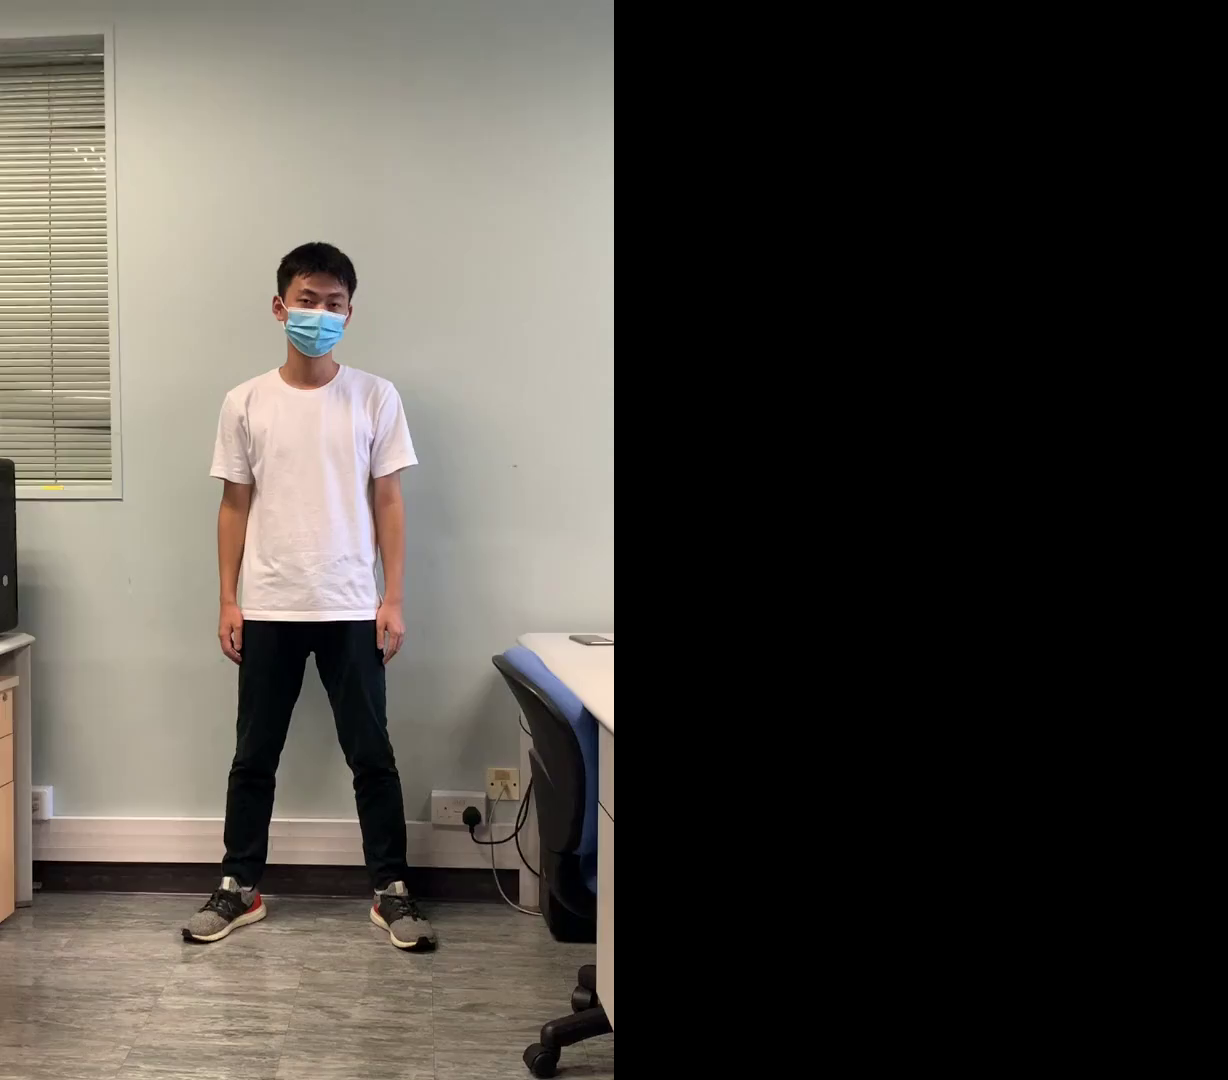

Visualization saved: ./mocap_output/rendered/00000.jpg
Processed : ./mocap_output/frames/00000.jpg
--------------------------------------


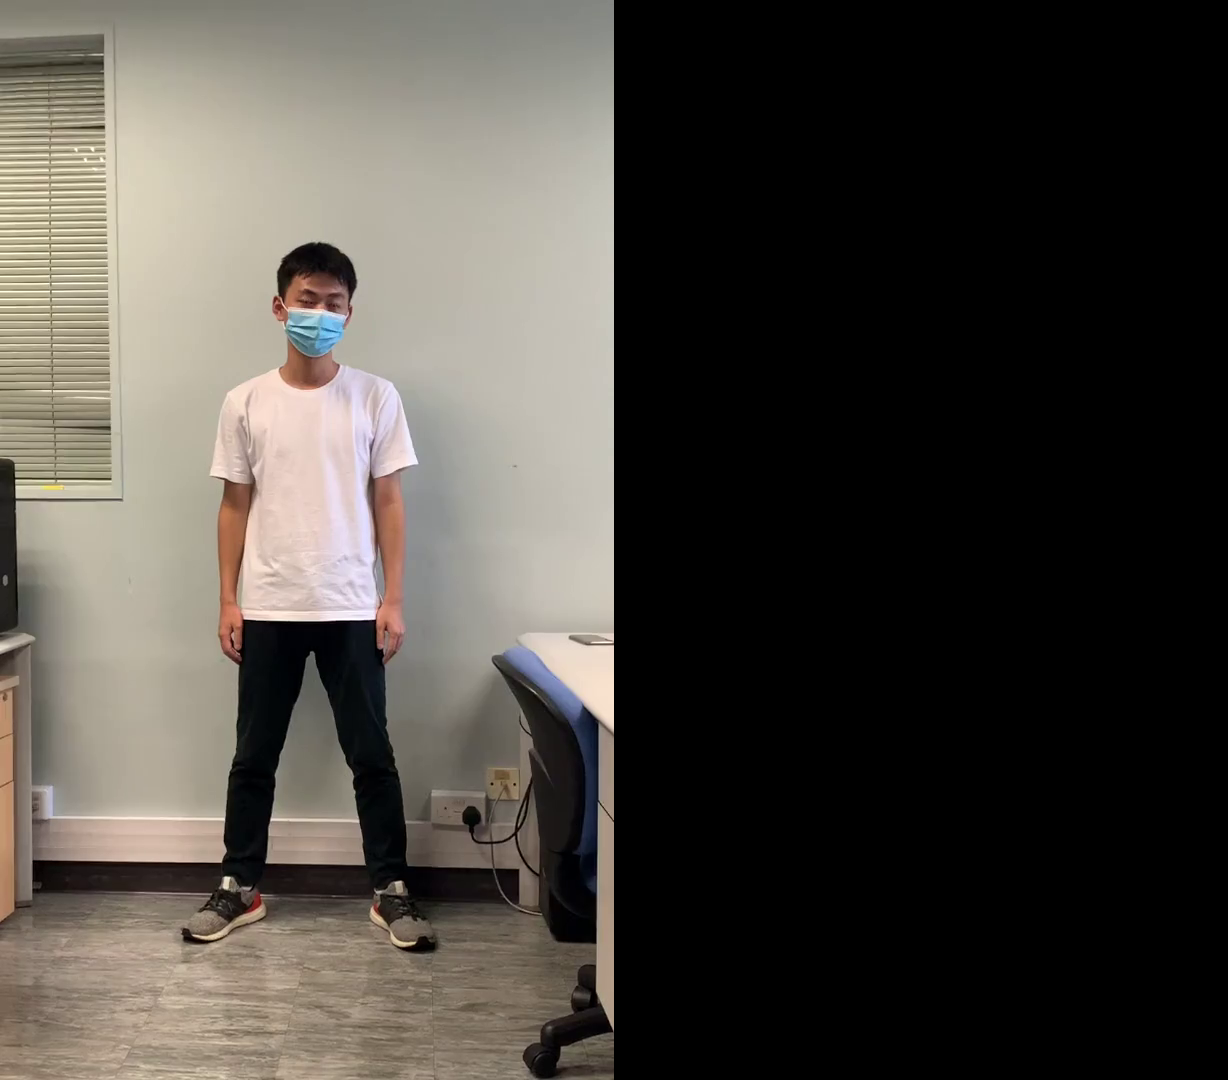

Visualization saved: ./mocap_output/rendered/00001.jpg
Processed : ./mocap_output/frames/00001.jpg
>> Generating video in ./mocap_output/single_totalbody.mp4


In [79]:
args = DemoOptions().parse(*[
  "--input_path", "./sample_data/single_totalbody.mp4",
  "--out_dir", "./mocap_output"
])
args.use_smplx = True
args.renderer_type = "pytorch3d"  # SET due to shutdown problem

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert torch.cuda.is_available(), "Current version only supports GPU"

hand_bbox_detector =  HandBboxDetector('third_view', device)

#Set Mocap regressor
body_mocap = BodyMocap(args.checkpoint_body_smplx, args.smpl_dir, device = device, use_smplx= True)
hand_mocap = HandMocap(args.checkpoint_hand, args.smpl_dir, device = device)

# Set Visualizer
if args.renderer_type in ['pytorch3d', 'opendr']:
    from renderer.screen_free_visualizer import Visualizer
else:
    from renderer.visualizer import Visualizer
visualizer = Visualizer(args.renderer_type)

pred_mesh_list = run_frank_mocap(args, hand_bbox_detector, body_mocap, hand_mocap, visualizer)

In [25]:
pred_mesh_list[0]

{'faces': array([[    3,     1,     0],
        [    7,     5,     4],
        [   12,    14,    13],
        ...,
        [ 9944, 10097, 10084],
        [ 9940, 10084, 10071],
        [10071, 10058,  9932]], dtype=int32),
 'vertices': array([[341.22858 , 320.44913 ,  -9.34357 ],
        [342.8176  , 321.03204 ,  -9.584909],
        [343.16882 , 320.51224 ,  -9.530871],
        ...,
        [306.85385 , 303.51077 , -37.550007],
        [307.62357 , 303.44388 , -36.972748],
        [308.49225 , 303.3652  , -36.55719 ]], dtype=float32)}

In [27]:
pred_mesh_list[0]['faces'].shape

(20908, 3)

In [26]:
pred_mesh_list[0]['vertices'].shape

(10475, 3)

#MultiGarmentNetwork



In [48]:
import os
os.chdir("/content")

In [39]:
! git clone https://github.com/bharat-b7/MultiGarmentNetwork.git
! cp /content/smplify_public/code/models/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl MultiGarmentNetwork/assets/neutral_smpl.pkl

fatal: destination path 'MultiGarmentNetwork' already exists and is not an empty directory.


In [40]:
# install Mesh Package
! sudo apt-get install libboost-dev
! git clone https://github.com/MPI-IS/mesh.git
! cd mesh; BOOST_INCLUDE_DIRS=/usr/include/boost make all

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-dev is already the newest version (1.65.1.0ubuntu1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsigh

In [49]:
# install chumpy
! pip install git+https://github.com/scottandrews/chumpy.git@fe51783e0364bf1e9b705541e7d77f894dd2b1ac

  Cloning https://github.com/scottandrews/chumpy.git (to revision fe51783e0364bf1e9b705541e7d77f894dd2b1ac) to /tmp/pip-req-build-0hnvgzj1
  Running command git clone -q https://github.com/scottandrews/chumpy.git /tmp/pip-req-build-0hnvgzj1
  Running command git rev-parse -q --verify 'sha^fe51783e0364bf1e9b705541e7d77f894dd2b1ac'
  Running command git fetch -q https://github.com/scottandrews/chumpy.git fe51783e0364bf1e9b705541e7d77f894dd2b1ac


In [42]:
# install opendr
! sudo apt-get install libglu1-mesa-dev freeglut3-dev mesa-common-dev
! sudo apt-get install libosmesa6-dev
! pip install opendr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglu1-mesa-dev is already the newest version (9.0.0-2.1build1).
freeglut3-dev is already the newest version (2.8.1-3).
mesa-common-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-n

In [43]:
# in /content/MultiGarmentNetwork/utils/smpl_paths.py change reading pickle 
# and SMPL_PATH smpl_vt_ft_path

In [44]:
# change EVERYWHERE: cPickle to pickle

# IN /content/MultiGarmentNetwork/utils/smpl_paths.py:75
# with open(smpl_vt_ft_path, 'rb') as f:
#     u = pkl._Unpickler(f)
#     u.encoding = 'latin1'
#     p = u.load()

In [50]:
import sys
sys.path.append("/usr/lib/python3.7/site-packages")
sys.path.append("MultiGarmentNetwork")
sys.path.append("MultiGarmentNetwork/lib")
sys.path.append("/content/SMPL_python_v.1.1.0/smpl/smpl_webuser") # fix posemaker

In [51]:
from psbody.mesh import Mesh, MeshViewers
import numpy as np
import pickle as pkl
from utils.smpl_paths import SmplPaths
from lib.ch_smpl import Smpl
from utils.interpenetration_ind import remove_interpenetration_fast
from os.path import join, split
from glob import glob

def load_smpl_from_file(file):
    with open(file, 'rb') as f:
      u = pkl._Unpickler(f)
      u.encoding = 'latin1'
      dat = u.load()
    dp = SmplPaths(gender=dat['gender'])
    smpl_h = Smpl(dp.get_hres_smpl_model_data())

    smpl_h.pose[:] = dat['pose']
    smpl_h.betas[:] = dat['betas']
    smpl_h.trans[:] = dat['trans']

    return smpl_h

def pose_garment(garment, vert_indices, smpl_params):
    '''
    :param smpl_params: dict with pose, betas, v_template, trans, gender
    '''
    dp = SmplPaths(gender=smpl_params['gender'])
    smpl = Smpl(dp.get_hres_smpl_model_data() )
    smpl.pose[:] = 0
    smpl.betas[:] = smpl_params['betas']
    # smpl.v_template[:] = smpl_params['v_template']

    offsets = np.zeros_like(smpl.r)
    offsets[vert_indices] = garment.v - smpl.r[vert_indices]
    smpl.v_personal[:] = offsets
    smpl.pose[:] = smpl_params['pose']
    smpl.trans[:] = smpl_params['trans']

    mesh = Mesh(smpl.r, smpl.f).keep_vertices(vert_indices)
    return mesh

def retarget(garment_mesh, src, tgt):
    '''
    For each vertex finds the closest point and
    :return:
    '''
    from psbody.mesh import Mesh
    verts, _ = src.closest_vertices(garment_mesh.v)
    verts = np.array(verts)
    tgt_garment = garment_mesh.v - src.v[verts] + tgt.v[verts]
    return Mesh(tgt_garment, garment_mesh.f)

def dress(smpl_tgt, body_src, garment, vert_inds, garment_tex = None):
    '''
    :param smpl: SMPL in the output pose
    :param garment: garment mesh in t-pose
    :param body_src: garment body in t-pose
    :param garment_tex: texture file
    :param vert_inds: vertex association b/w smpl and garment
    :return:
    To use texture files, garments must have vt, ft
    '''
    tgt_params = {'pose': np.array(smpl_tgt.pose.r), 'trans': np.array(smpl_tgt.trans.r), 'betas': np.array(smpl_tgt.betas.r), 'gender': 'neutral'}
    smpl_tgt.pose[:] = 0
    body_tgt = Mesh(smpl_tgt.r, smpl_tgt.f)

    ## Re-target
    ret = retarget(garment, body_src, body_tgt)

    ## Re-pose
    ret_posed = pose_garment(ret, vert_inds, tgt_params)
    body_tgt_posed = pose_garment(body_tgt, range(len(body_tgt.v)), tgt_params)

    ## Remove intersections
    ret_posed_interp = remove_interpenetration_fast(ret_posed, body_tgt_posed)
    ret_posed_interp.vt = garment.vt
    ret_posed_interp.ft = garment.ft
    ret_posed_interp.set_texture_image(garment_tex)

    return ret_posed_interp

path = '/content/Multi-Garment_dataset/'
all_scans = glob(path + '*')
garment_classes = ['Pants', 'ShortPants', 'ShirtNoCoat', 'TShirtNoCoat', 'LongCoat']
gar_dict = {}
for gar in garment_classes:
    gar_dict[gar] = glob(join(path, '*', gar + '.obj'))

if __name__ == '__main__':
    dp = SmplPaths()
    vt, ft = dp.get_vt_ft_hres()
    smpl = Smpl(dp.get_hres_smpl_model_data())

    ## This file contains correspondances between garment vertices and smpl body
    fts_file = '/content/MultiGarmentNetwork/assets/garment_fts.pkl'
    with open(fts_file, 'rb') as f:
        u = pkl._Unpickler(f)
        u.encoding = 'latin1'
        vert_indices, fts = u.load()
    fts['naked'] = ft

    ## Choose any garmet type as source
    garment_type = 'TShirtNoCoat'
    index = np.random.randint(0, len(gar_dict[garment_type]))   ## Randomly pick from the digital wardrobe
    path = split(gar_dict[garment_type][index])[0]


    garment_org_body_unposed = load_smpl_from_file(join(path, 'registration.pkl'))
    garment_org_body_unposed.pose[:] = 0
    garment_org_body_unposed.trans[:] = 0
    garment_org_body_unposed = Mesh(garment_org_body_unposed.v, garment_org_body_unposed.f)

    garment_unposed = Mesh(filename=join(path, garment_type + '.obj'))
    garment_tex = join(path, 'multi_tex.jpg')

    ## Generate random SMPL body (Feel free to set up ur own smpl) as target subject
    smpl.pose[:] = np.random.randn(72) *0.05
    smpl.betas[:] = np.random.randn(10) *0.01
    smpl.trans[:] = 0
    tgt_body = Mesh(smpl.r, smpl.f)

    vert_inds = vert_indices[garment_type]
    garment_unposed.set_texture_image(garment_tex)

    new_garment = dress(smpl, garment_org_body_unposed, garment_unposed, vert_inds, garment_tex)

    mvs = MeshViewers((1, 2))
    mvs[0][0].set_static_meshes([garment_unposed])
    mvs[0][1].set_static_meshes([new_garment, tgt_body])

    print('Done')

OpenGL test failed: 
	stdout: 
	stderr: /
u
s
r
/
b
i
n
/
p
y
t
h
o
n
3
:
 
E
r
r
o
r
 
w
h
i
l
e
 
f
i
n
d
i
n
g
 
m
o
d
u
l
e
 
s
p
e
c
i
f
i
c
a
t
i
o
n
 
f
o
r
 
'
p
s
b
o
d
y
.
m
e
s
h
.
m
e
s
h
v
i
e
w
e
r
'
 
(
M
o
d
u
l
e
N
o
t
F
o
u
n
d
E
r
r
o
r
:
 
N
o
 
m
o
d
u
l
e
 
n
a
m
e
d
 
'
p
s
b
o
d
y
'
)


Done


In [55]:
! cp -r /content/MultiGarmentNetwork /content/drive/MyDrive/dls_part1_project_vto/

In [62]:
new_garment.v.shape

(7702, 3)

In [63]:
new_garment.f.shape

(15180, 3)

# Multi-Garment Network with frankmocap

In [ ]:
import os
import sys
import os.path as osp
import torch
from torchvision.transforms import Normalize
import numpy as np
import cv2
import argparse
import json
import pickle
from IPython.display import clear_output
import matplotlib.pyplot as plt

############# input parameters  #############
# from demo.demo_options import DemoOptions  # mentioned above 
from bodymocap.body_mocap_api import BodyMocap
from handmocap.hand_mocap_api import HandMocap
import mocap_utils.demo_utils as demo_utils
import mocap_utils.general_utils as gnu
from mocap_utils.timer import Timer
from datetime import datetime

from bodymocap.body_bbox_detector import BodyPoseEstimator
from handmocap.hand_bbox_detector import HandBboxDetector
from integration.copy_and_paste import integration_copy_paste

import renderer.image_utils as imu
from renderer.viewer2D import ImShow


def __filter_bbox_list(body_bbox_list, hand_bbox_list, single_person):
    # (to make the order as consistent as possible without tracking)
    bbox_size =  [ (x[2] * x[3]) for x in body_bbox_list]
    idx_big2small = np.argsort(bbox_size)[::-1]
    body_bbox_list = [ body_bbox_list[i] for i in idx_big2small ]
    hand_bbox_list = [hand_bbox_list[i] for i in idx_big2small]

    if single_person and len(body_bbox_list)>0:
        body_bbox_list = [body_bbox_list[0], ]
        hand_bbox_list = [hand_bbox_list[0], ]

    return body_bbox_list, hand_bbox_list


def run_regress(
    args, img_original_bgr, 
    body_bbox_list, hand_bbox_list, bbox_detector,
    body_mocap, hand_mocap
):
    cond1 = len(body_bbox_list) > 0 and len(hand_bbox_list) > 0
    cond2 = not args.frankmocap_fast_mode

    # use pre-computed bbox or use slow detection mode
    if cond1 or cond2:
        if not cond1 and cond2:
            # run detection only when bbox is not available
            body_pose_list, body_bbox_list, hand_bbox_list, _ = \
                bbox_detector.detect_hand_bbox(img_original_bgr.copy())
        else:
            print("Use pre-computed bounding boxes")
        assert len(body_bbox_list) == len(hand_bbox_list)

        if len(body_bbox_list) < 1: 
            return list(), list(), list()

        # sort the bbox using bbox size 
        # only keep on bbox if args.single_person is set
        body_bbox_list, hand_bbox_list = __filter_bbox_list(
            body_bbox_list, hand_bbox_list, args.single_person)

        # hand & body pose regression
        pred_hand_list = hand_mocap.regress(
            img_original_bgr, hand_bbox_list, add_margin=True)
        pred_body_list = body_mocap.regress(img_original_bgr, body_bbox_list)
        assert len(hand_bbox_list) == len(pred_hand_list)
        assert len(pred_hand_list) == len(pred_body_list)

    else:
        _, body_bbox_list = bbox_detector.detect_body_bbox(img_original_bgr.copy())

        if len(body_bbox_list) < 1: 
            return list(), list(), list()

        # sort the bbox using bbox size 
        # only keep on bbox if args.single_person is set
        hand_bbox_list = [None, ] * len(body_bbox_list)
        body_bbox_list, _ = __filter_bbox_list(
            body_bbox_list, hand_bbox_list, args.single_person)

        # body regression first 
        pred_body_list = body_mocap.regress(img_original_bgr, body_bbox_list)
        assert len(body_bbox_list) == len(pred_body_list)

        # get hand bbox from body
        hand_bbox_list = body_mocap.get_hand_bboxes(pred_body_list, img_original_bgr.shape[:2])
        assert len(pred_body_list) == len(hand_bbox_list)

        # hand regression
        pred_hand_list = hand_mocap.regress(
            img_original_bgr, hand_bbox_list, add_margin=True)
        assert len(hand_bbox_list) == len(pred_hand_list) 

    # integration by copy-and-paste
    integral_output_list = integration_copy_paste(
        pred_body_list, pred_hand_list, body_mocap.smpl, img_original_bgr.shape)
    
    return body_bbox_list, hand_bbox_list, integral_output_list


def run_frank_mocap(args, bbox_detector, body_mocap, hand_mocap, visualizer):
    #Setup input data to handle different types of inputs
    input_type, input_data = demo_utils.setup_input(args)

    cur_frame = args.start_frame
    video_frame = 0
    while True:
        # load data
        load_bbox = False

        if input_type =='image_dir':
            if cur_frame < len(input_data):
                image_path = input_data[cur_frame]
                img_original_bgr  = cv2.imread(image_path)
            else:
                img_original_bgr = None

        elif input_type == 'bbox_dir':
            if cur_frame < len(input_data):
                image_path = input_data[cur_frame]['image_path']
                hand_bbox_list = input_data[cur_frame]['hand_bbox_list']
                body_bbox_list = input_data[cur_frame]['body_bbox_list']
                img_original_bgr  = cv2.imread(image_path)
                load_bbox = True
            else:
                img_original_bgr = None

        elif input_type == 'video':      
            _, img_original_bgr = input_data.read()
            if video_frame < cur_frame:
                video_frame += 1
                continue
          # save the obtained video frames
            image_path = osp.join(args.out_dir, "frames", f"{cur_frame:05d}.jpg")
            if img_original_bgr is not None:
                video_frame += 1
                if args.save_frame:
                    gnu.make_subdir(image_path)
                    cv2.imwrite(image_path, img_original_bgr)
        
        elif input_type == 'webcam':
            _, img_original_bgr = input_data.read()

            if video_frame < cur_frame:
                video_frame += 1
                continue
            # save the obtained video frames
            image_path = osp.join(args.out_dir, "frames", f"scene_{cur_frame:05d}.jpg")
            if img_original_bgr is not None:
                video_frame += 1
                if args.save_frame:
                    gnu.make_subdir(image_path)
                    cv2.imwrite(image_path, img_original_bgr)
        else:
            assert False, "Unknown input_type"

        cur_frame +=1
        if img_original_bgr is None or cur_frame > args.end_frame:
            break   
        print("--------------------------------------")
        
        # bbox detection
        if not load_bbox:
            body_bbox_list, hand_bbox_list = list(), list()
        
        # regression (includes integration)
        body_bbox_list, hand_bbox_list, pred_output_list = run_regress(
            args, img_original_bgr, 
            body_bbox_list, hand_bbox_list, bbox_detector,
            body_mocap, hand_mocap)

        # save the obtained body & hand bbox to json file
        if args.save_bbox_output: 
            demo_utils.save_info_to_json(args, image_path, body_bbox_list, hand_bbox_list)

        if len(body_bbox_list) < 1: 
            print(f"No body deteced: {image_path}")
            continue

        pred_mesh_list = demo_utils.extract_mesh_from_output(pred_output_list)

        # visualization
        res_img = visualizer.visualize(
            img_original_bgr,
            pred_mesh_list = pred_mesh_list,)
            # body_bbox_list = body_bbox_list,
            # hand_bbox_list = hand_bbox_list)
        
       # show result in the screen
        if not args.no_display:
            res_img = res_img.astype(np.uint8)
            ImShow(res_img)

        # save result image
        if args.out_dir is not None:
            demo_utils.save_res_img(args.out_dir, image_path, res_img)

        # save predictions to pkl
        if args.save_pred_pkl:
            demo_type = 'frank'
            demo_utils.save_pred_to_pkl(
                args, demo_type, image_path, body_bbox_list, hand_bbox_list, pred_output_list)
        print(f"Processed : {image_path}")
        if cur_frame == 2:
          break


    # save images as a video
    if not args.no_video_out and input_type in ['video', 'webcam']:
        demo_utils.gen_video_out(args.out_dir, args.seq_name)

    if input_type =='webcam' and input_data is not None:
        input_data.release()
    cv2.destroyAllWindows()
    return pred_mesh_list

In [ ]:
args = DemoOptions().parse(*[
  "--input_path", "./sample_data/single_totalbody.mp4",
  "--out_dir", "./mocap_output"
])
args.use_smplx = True
args.renderer_type = "pytorch3d"  # SET due to shutdown problem

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert torch.cuda.is_available(), "Current version only supports GPU"

hand_bbox_detector =  HandBboxDetector('third_view', device)

#Set Mocap regressor
body_mocap = BodyMocap(args.checkpoint_body_smplx, args.smpl_dir, device = device, use_smplx= True)
hand_mocap = HandMocap(args.checkpoint_hand, args.smpl_dir, device = device)

# Set Visualizer
if args.renderer_type in ['pytorch3d', 'opendr']:
    from renderer.screen_free_visualizer import Visualizer
else:
    from renderer.visualizer import Visualizer
visualizer = Visualizer(args.renderer_type)

pred_mesh_list = run_frank_mocap(args, hand_bbox_detector, body_mocap, hand_mocap, visualizer)